#### Library import

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

from tensorflow import keras

import re
from tqdm import tqdm

#### GPU setting

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [3]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config = config)

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8369347279078100561
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3435973836
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17252032416444264415
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [5]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

#### Data import and preprocessing

In [6]:
data = pd.read_csv("data/data.csv")
data.columns

Index(['OBJECTID_x', 'ID', 'pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope',
       'altitude', 'profile_curve', 'profile_c_num', 'profile_c_abs',
       'planform_curve', 'planform_c_num', 'planform_c_abs', 'HYDGRP',
       'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C', 'HYDGRP_D', 'ANION_EXCL', 'SOL_CRK',
       'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'SOL_EC1', 'distance'],
      dtype='object')

In [7]:
data = data.drop(['OBJECTID_x','ID','HYDGRP','profile_c_num', 'profile_c_abs','planform_c_num', 'planform_c_abs','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
data.columns

Index(['pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope', 'altitude',
       'profile_curve', 'planform_curve', 'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C',
       'HYDGRP_D', 'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'distance'],
      dtype='object')

In [8]:
As = data
Cd = data
Ni = data

In [9]:
As = As.drop(["Cd", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Cd = Cd.drop(["As", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Ni = Ni.drop(["As", "Cd", "Pb", "Zn", "Hg"], axis = 1)

#### Oversampling by SMOGN (SMOTE Regression)

In [10]:
import smogn

In [11]:
As_smogn = smogn.smoter(data = As, y = 'As', samp_method = 'extreme')
Cd_smogn = smogn.smoter(data = Cd, y = 'Cd', samp_method = 'extreme')
Ni_smogn = smogn.smoter(data = Ni, y = 'Ni', samp_method = 'extreme')

synth_matrix: 100%|##########| 242/242 [00:01<00:00, 154.11it/s]


#### Eliminate outlier and train / test split

In [12]:
def eli_outlier(data, value):
    q1 = data[value].quantile(0.25)
    q3 = data[value].quantile(0.75)

    iqr = q3 - q1

    q1_condition = data[value] < q1-1.5*iqr
    q3_condition = data[value] > q3+1.5*iqr

    reset_q1_index = data[q1_condition].index
    reset_q3_index = data[q3_condition].index

    data.drop(reset_q1_index, inplace = True)
    data.drop(reset_q3_index, inplace = True)

    return data

In [13]:
As_ros = eli_outlier(As_smogn, "As")
Cd_ros = eli_outlier(Cd_smogn, "Cd")
Ni_ros = eli_outlier(Ni_smogn, "Ni")

In [14]:
As_X = As_ros.drop(["As"], axis=1)
Cd_X = Cd_ros.drop(["Cd"], axis=1)
Ni_X = Ni_ros.drop(["Ni"], axis=1)

As_y = As_ros["As"]
Cd_y = Cd_ros["Cd"]
Ni_y = Ni_ros["Ni"]

In [15]:
As_y = np.log1p(As_ros["As"])
Cd_y = np.log1p(Cd_ros["Cd"])
Ni_y = np.log1p(Ni_ros["Ni"])

In [16]:
print(As_X.shape)
print(Cd_X.shape)
print(Ni_X.shape)

(1644, 15)
(1740, 15)
(2058, 15)


StandardScaler

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
As_X_scaled = scaler.fit_transform(As_X)
Cd_X_scaled = scaler.fit_transform(Cd_X)
Ni_X_scaled = scaler.fit_transform(Ni_X)

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

MinMaxScaler

In [73]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# As_X_scaled = scaler.fit_transform(As_X)
# Cd_X_scaled = scaler.fit_transform(Cd_X)
# Ni_X_scaled = scaler.fit_transform(Ni_X)

# As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
# Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
# Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

In [18]:
print(As_X_train.shape)
print(Cd_X_train.shape)
print(Ni_X_train.shape)

(1315, 15)
(1392, 15)
(1646, 15)


#### 10-Fold Crossvalidation

In [19]:
# kf = KFold(n_splits = 10, random_state = 42, shuffle = True)

#### Optuna Optimization

In [20]:
import optuna

from optuna import Trial
from optuna.samplers import TPESampler

In [21]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR


def objectiveSVM(trial: Trial, X_train, y_train) -> float:
    C = trial.suggest_loguniform('C', 0.1, 100.0)
    epsilon = trial.suggest_loguniform('epsilon', 0.01, 1.0)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    degree = trial.suggest_int('degree', 1, 5)
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    model = SVR(C=C, epsilon=epsilon, kernel=kernel, degree=degree)

    r2 = cross_val_score(model, X_train, y_train, scoring='r2', cv=kf)
    r2 = r2.mean()

    return r2


####  Optimization

In [22]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="svm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveSVM(trial, As_X_train, As_y_train), n_trials=1000)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-14 19:36:24,002] A new study created in memory with name: svm_parameter_opt
[I 2023-08-14 19:36:24,529] Trial 0 finished with value: 0.41667249448819454 and parameters: {'C': 13.783479806441692, 'epsilon': 0.11730812222332256, 'kernel': 'rbf', 'degree': 3}. Best is trial 0 with value: 0.41667249448819454.
[I 2023-08-14 19:36:24,655] Trial 1 finished with value: 0.1753969342645128 and parameters: {'C': 0.3175053840075535, 'epsilon': 0.9157304268712699, 'kernel': 'linear', 'degree': 2}. Best is trial 0 with value: 0.41667249448819454.
[I 2023-08-14 19:36:36,431] Trial 2 finished with value: 0.17676214769545284 and parameters: {'C': 45.21876597319138, 'epsilon': 0.01620929367265355, 'kernel': 'linear', 'degree': 5}. Best is trial 0 with value: 0.41667249448819454.
[I 2023-08-14 19:36:46,197] Trial 3 finished with value: -31.615442196503047 and parameters: {'C': 96.77366690883154, 'epsilon': 0.04320533265474475, 'kernel': 'poly', 'degree': 3}. Best is trial 0 with value: 0.41667

Best r2:  0.4375917201135179
Best trial: {'C': 4.194004895739116, 'epsilon': 0.17942261460899583, 'kernel': 'rbf', 'degree': 1}


In [23]:
optuna.visualization.plot_parallel_coordinate(study)

In [24]:
print("Best trial:", study.best_trial.params)

Best trial: {'C': 4.194004895739116, 'epsilon': 0.17942261460899583, 'kernel': 'rbf', 'degree': 1}


In [25]:
svm_params = {
    "C": study.best_trial.params["C"],
    "epsilon": study.best_trial.params["epsilon"],
    "kernel": study.best_trial.params["kernel"],
    "degree": study.best_trial.params["degree"]
}

svm = SVR(**svm_params)
svm.fit(As_X_train, As_y_train)

SVR(C=4.194004895739116, degree=1, epsilon=0.17942261460899583)

In [26]:
y_train_pred = svm.predict(As_X_train)
y_test_pred = svm.predict(As_X_test)

In [83]:
# plt.scatter(y_train_pred, np.array(As_y_train))

In [27]:
print("Train RMSE: ", np.sqrt(mean_squared_error(As_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(As_y_test, y_test_pred)))

Train RMSE:  0.4612564402208203
Test RMSE:  0.5448520821838768


In [28]:
print("Train R2: ", r2_score(As_y_train, y_train_pred))
print("Test R2: ", r2_score(As_y_test, y_test_pred))

Train R2:  0.6337550567742145
Test R2:  0.5207184224928889


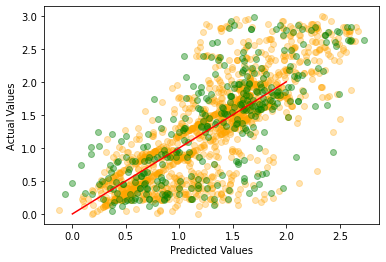

In [29]:
plt.scatter(y_train_pred, np.array(As_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(As_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 2.0], [0, 2.0], color='red', linestyle='-')

plt.show()

Cd

Optimization

In [30]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="svm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveSVM(trial, Cd_X_train, Cd_y_train), n_trials=1000)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-14 19:43:56,641] A new study created in memory with name: svm_parameter_opt
[I 2023-08-14 19:43:56,870] Trial 0 finished with value: 0.09622470475804343 and parameters: {'C': 0.3226130746938671, 'epsilon': 0.12775355433854302, 'kernel': 'poly', 'degree': 5}. Best is trial 0 with value: 0.09622470475804343.
[I 2023-08-14 19:43:57,276] Trial 1 finished with value: 0.24829243235317353 and parameters: {'C': 1.307658952258837, 'epsilon': 0.028416404354972048, 'kernel': 'poly', 'degree': 1}. Best is trial 1 with value: 0.24829243235317353.
[I 2023-08-14 19:43:59,972] Trial 2 finished with value: 0.25218660794398107 and parameters: {'C': 2.1955969672174187, 'epsilon': 0.011151230230314245, 'kernel': 'linear', 'degree': 4}. Best is trial 2 with value: 0.25218660794398107.
[I 2023-08-14 19:44:07,459] Trial 3 finished with value: 0.25433750598721294 and parameters: {'C': 10.503914345234756, 'epsilon': 0.07986534228418175, 'kernel': 'linear', 'degree': 4}. Best is trial 3 with value: 0

Best r2:  0.5293274920456263
Best trial: {'C': 4.772653486826759, 'epsilon': 0.06478694108269326, 'kernel': 'rbf', 'degree': 1}


In [31]:
optuna.visualization.plot_parallel_coordinate(study)

In [32]:
print("Best trial:", study.best_trial.params)

Best trial: {'C': 4.772653486826759, 'epsilon': 0.06478694108269326, 'kernel': 'rbf', 'degree': 1}


In [33]:
svm_params = {
    "C": study.best_trial.params["C"],
    "epsilon": study.best_trial.params["epsilon"],
    "kernel": study.best_trial.params["kernel"],
    "degree": study.best_trial.params["degree"]
}

svm = SVR(**svm_params)
svm.fit(Cd_X_train, Cd_y_train)

SVR(C=4.772653486826759, degree=1, epsilon=0.06478694108269326)

In [34]:
y_train_pred = svm.predict(Cd_X_train)
y_test_pred = svm.predict(Cd_X_test)

In [35]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Cd_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Cd_y_test, y_test_pred)))

Train RMSE:  0.1218609004252654
Test RMSE:  0.16026155869011194


In [36]:
print("Train R2: ", r2_score(Cd_y_train, y_train_pred))
print("Test R2: ", r2_score(Cd_y_test, y_test_pred))

Train R2:  0.7274993010412969
Test R2:  0.5672792928779511


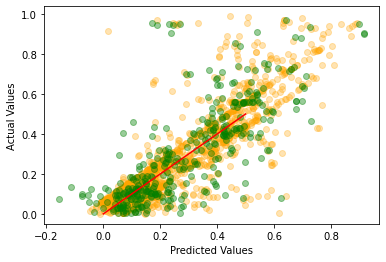

In [37]:
plt.scatter(y_train_pred, np.array(Cd_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Cd_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 0.5], [0, 0.5], color='red', linestyle='-')

plt.show()

Ni

In [38]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="svm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveSVM(trial, Ni_X_train, Ni_y_train), n_trials=1000)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-14 19:55:37,171] A new study created in memory with name: svm_parameter_opt
[I 2023-08-14 19:55:37,724] Trial 0 finished with value: 0.445285695866216 and parameters: {'C': 1.1329762778315906, 'epsilon': 0.058098586651463516, 'kernel': 'rbf', 'degree': 1}. Best is trial 0 with value: 0.445285695866216.
[I 2023-08-14 19:55:38,256] Trial 1 finished with value: 0.11595804749972036 and parameters: {'C': 0.21396385990715677, 'epsilon': 0.024158452300969375, 'kernel': 'linear', 'degree': 2}. Best is trial 0 with value: 0.445285695866216.
[I 2023-08-14 19:55:38,714] Trial 2 finished with value: -0.08126477767638965 and parameters: {'C': 0.5827804378784778, 'epsilon': 0.02847244328552174, 'kernel': 'poly', 'degree': 3}. Best is trial 0 with value: 0.445285695866216.
[I 2023-08-14 19:55:39,195] Trial 3 finished with value: 0.11550897240887618 and parameters: {'C': 0.19457473517568005, 'epsilon': 0.018546385066035093, 'kernel': 'linear', 'degree': 4}. Best is trial 0 with value: 0.445

Best r2:  0.5436402773908161
Best trial: {'C': 19.479892600838284, 'epsilon': 0.45187542693785915, 'kernel': 'rbf', 'degree': 3}


In [39]:
optuna.visualization.plot_parallel_coordinate(study)

In [40]:
print("Best trial:", study.best_trial.params)

Best trial: {'C': 19.479892600838284, 'epsilon': 0.45187542693785915, 'kernel': 'rbf', 'degree': 3}


In [41]:
svm_params = {
    "C": study.best_trial.params["C"],
    "epsilon": study.best_trial.params["epsilon"],
    "kernel": study.best_trial.params["kernel"],
    "degree": study.best_trial.params["degree"]
}

svm = SVR(**svm_params)
svm.fit(Ni_X_train, Ni_y_train)

SVR(C=19.479892600838284, epsilon=0.45187542693785915)

In [42]:
y_train_pred = svm.predict(Ni_X_train)
y_test_pred = svm.predict(Ni_X_test)

In [43]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Ni_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Ni_y_test, y_test_pred)))

Train RMSE:  0.6023114186631172
Test RMSE:  0.7132799563648697


In [44]:
print("Train R2: ", r2_score(Ni_y_train, y_train_pred))
print("Test R2: ", r2_score(Ni_y_test, y_test_pred))

Train R2:  0.7491451499749486
Test R2:  0.62087727240168


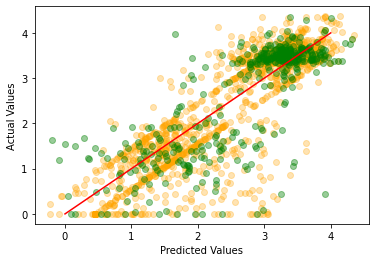

In [45]:
plt.scatter(y_train_pred, np.array(Ni_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Ni_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()